In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from utils.utils_decomposition import tucker_decomposition_conv_layer
import matplotlib.pyplot as plt

In [2]:
# ImageNet 사전 학습된 ResNet18 모델 로드
resnet18 = models.resnet18(pretrained=True)
# 학습된 ResNet18 가중치 복원 (Cifar10, epochs10)
resnet18.load_state_dict(torch.load("resnet18_cifar10.pth"))

<All keys matched successfully>

In [3]:
# CIFAR-10의 이미지 크기는 32x32이므로, 이를 ResNet의 입력 크기인 224x224로 변경하기 위한 전처리
transform = transforms.Compose([
    transforms.Resize(224),  # 이미지 크기 변경
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 데이터셋에 대한 정규화
])

In [4]:
# CIFAR-10 학습 및 검증 데이터 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Loss 함수 및 optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# GPU 사용 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# # 학습 코드
# num_epochs = 10
# for epoch in range(num_epochs):
#     resnet18.train()
#     for i, (inputs, labels) in enumerate(train_loader, 0):
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         outputs = resnet18(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# print('Finished Training')

In [7]:
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

accuracy = evaluate(resnet18, test_loader, device)
print(f"Top-1 Accuracy: {accuracy * 100:.2f}%")


Top-1 Accuracy: 94.44%


# Tensor Decomposition

In [8]:
def get_conv_layers_with_kernel_size_3(model):
    conv_layers = []
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d) and layer.kernel_size == (3, 3):
            conv_layers.append((name, layer))
    return conv_layers

conv_layers = get_conv_layers_with_kernel_size_3(resnet18)

for name, layer in conv_layers:
    print(name, layer)


layer1.0.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.conv1 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer2.0.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.1.conv1 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.1.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.0.conv1 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer3.0.conv2 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.1.conv1 Conv2d(256, 256, kernel_size=(3, 3), stride=

In [9]:
# 각 합성곱 레이어에 대해 텐서 분해 수행
for idx, (name, conv_layer) in enumerate(conv_layers):
    print(name, conv_layer)
    # factorized_layers는 분해된 레이어들
    factorized_layers = tucker_decomposition_conv_layer(conv_layer.cpu())
    
    pointer = resnet18
    names = name.split('.')
    for n in names[:-1]:  # 마지막 이름을 제외하고 모든 중간 모듈을 참조
        pointer = getattr(pointer, n)
    setattr(pointer, names[-1], factorized_layers)  # 마지막 모듈에 factorized_layers 할당


layer1.0.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.conv1 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer2.0.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.1.conv1 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.1.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.0.conv1 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer3.0.conv2 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.1.conv1 Conv2d(256, 256, kernel_size=(3, 3), stride=

In [10]:
accuracy = evaluate(resnet18.cuda(), test_loader, device)
print(accuracy)

0.1269


In [11]:
# 학습 코드 (Fine tuning)
num_epochs = 10
for epoch in range(num_epochs):
    resnet18.train()
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    accuracy = evaluate(resnet18, test_loader, device)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%")

print('Finished Training')

Epoch 1/10, Loss: 0.11328447610139847, Accuracy: 84.03%
Epoch 2/10, Loss: 0.7951287031173706, Accuracy: 85.83%
Epoch 3/10, Loss: 0.13058844208717346, Accuracy: 86.98%
Epoch 4/10, Loss: 0.4580053687095642, Accuracy: 87.71%
Epoch 5/10, Loss: 0.7302859425544739, Accuracy: 88.10%
Epoch 6/10, Loss: 0.315093994140625, Accuracy: 88.15%
Epoch 7/10, Loss: 0.32907912135124207, Accuracy: 88.63%
Epoch 8/10, Loss: 0.4826359152793884, Accuracy: 88.80%
Epoch 9/10, Loss: 0.24381054937839508, Accuracy: 89.25%
Epoch 10/10, Loss: 0.11716306954622269, Accuracy: 89.17%
Finished Training


In [13]:
torch.save(resnet18.state_dict(), "resnet18_decomposed_cifar10_weight.pth")
torch.save(resnet18, 'resnet18_decomposed_cifar10_include_model_struct.pth')


# Compare the number of parameters

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def compare_parameters(model1, model2):
    model1_params = count_parameters(model1)
    model2_params = count_parameters(model2)
    
    return model1_params, model2_params

def plot_parameters_comparison(model1_params, model2_params, model1_name='Model1', model2_name='Model2'):
    max_params = max(model1_params, model2_params)

    model1_percentage = (model1_params / max_params) * 100
    model2_percentage = (model2_params / max_params) * 100
    
    fig, ax = plt.subplots()
    ax.bar(model1_name, model1_percentage, label=f'{model1_name} ({model1_percentage:.2f}%)')
    ax.bar(model2_name, model2_percentage, label=f'{model2_name} ({model2_percentage:.2f}%)')
    
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Parameter comparison by percentage')
    ax.legend()
    plt.show()

In [19]:
# ImageNet 사전 학습된 ResNet18 모델 로드
resnet18 = models.resnet18(pretrained=True)
# 학습된 ResNet18 가중치 복원 (Cifar10, epochs10)
resnet18.load_state_dict(torch.load("resnet18_cifar10.pth"))

resnet18_decomposed = torch.load('resnet18_decomposed_cifar10_include_model_struct.pth')

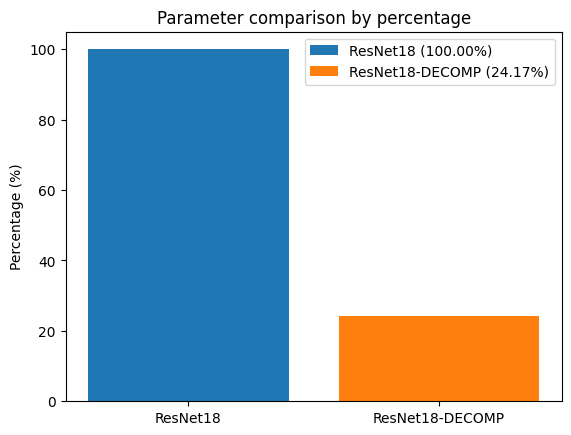

In [20]:
resnet18_params, resnet18_decomposed_params = compare_parameters(resnet18, resnet18_decomposed)
plot_parameters_comparison(resnet18_params, resnet18_decomposed_params, 'ResNet18', 'ResNet18-DECOMP')
